In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize

### Import data

In [37]:
# Import data
data_7_16_2025 = pd.read_csv('daily-treasury-rates.csv')

In [38]:
data_7_16_2025

,Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.40,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01
1,7/15/2025,4.36,4.40,4.46,4.42,4.43,4.33,4.12,3.95,3.93,4.05,4.26,4.50,5.02,5.01
2,7/14/2025,4.37,4.41,4.46,4.42,4.42,4.31,4.08,3.90,3.86,3.98,4.19,4.43,4.97,4.97
3,7/11/2025,4.37,4.39,4.47,4.41,4.42,4.31,4.09,3.90,3.86,3.99,4.19,4.43,4.96,4.96
4,7/10/2025,4.36,4.39,4.47,4.42,4.42,4.31,4.07,3.86,3.82,3.93,4.12,4.35,4.87,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1/8/2025,4.41,NaN,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91
130,1/7/2025,4.42,NaN,4.35,4.35,4.31,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
131,1/6/2025,4.43,NaN,4.36,4.35,4.31,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
132,1/3/2025,4.44,NaN,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82


### Plotting the data

In [39]:
# only first row
date_7_16_2025 = data_7_16_2025.iloc[0:1]
date_7_16_2025.reset_index(drop=True , inplace=True)
date_7_16_2025

,Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.4,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01


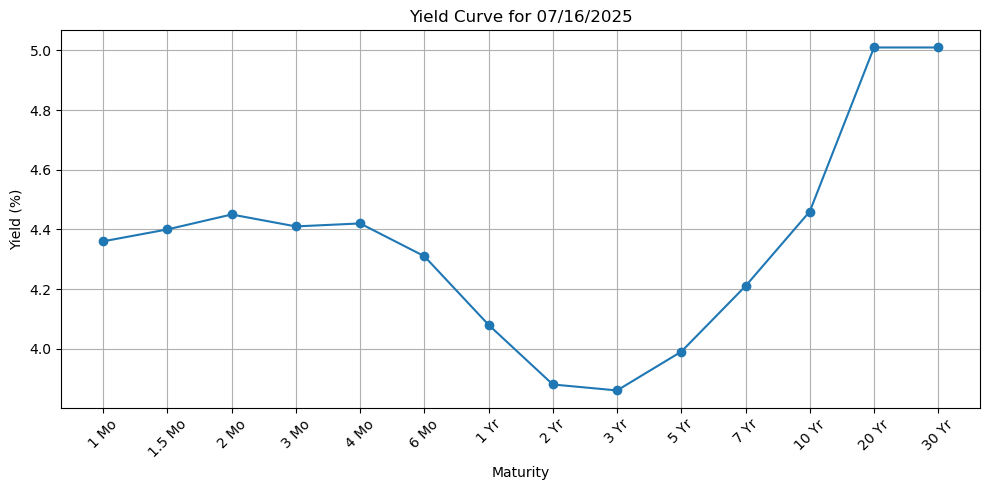

In [40]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(date_7_16_2025.columns[1:], date_7_16_2025.iloc[0, 1:], marker='o')
plt.title('Yield Curve for 07/16/2025')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### Data preparation

In [41]:
# def maturity in years
def convert_maturity_to_years(maturity):
    if 'Yr' in maturity:
        return float(maturity.replace('Yr', '').strip())
    elif 'Mo' in maturity:
        return float(maturity.replace('Mo', '').strip()) / 12

In [42]:
# transpose the data for better readability and remove date row and rename columns
data_7_16_2025 = date_7_16_2025.T
data_7_16_2025.columns = ['Yield %']
data_7_16_2025 = data_7_16_2025.iloc[1:]
data_7_16_2025.reset_index(inplace=True)
data_7_16_2025.rename(columns={'index': 'Maturity'}, inplace=True)

# Adding the 'Maturity' column as a numeric type as a new column. If Yr , then extract the number. If Mo, then convert to years dividing by 12.
data_7_16_2025['Maturity (Years)'] = round(data_7_16_2025['Maturity'].apply(convert_maturity_to_years),3)
data_7_16_2025

,Maturity,Yield %,Maturity (Years)
0,1 Mo,4.36,0.083
1,1.5 Mo,4.4,0.125
2,2 Mo,4.45,0.167
3,3 Mo,4.41,0.250
4,4 Mo,4.42,0.333
5,6 Mo,4.31,0.500
6,1 Yr,4.08,1.000
7,2 Yr,3.88,2.000
8,3 Yr,3.86,3.000
9,5 Yr,3.99,5.000


## Nelson Siegel Model

### Calibration using non linear curve fitting

In [43]:
# NS model calibration
def nelson_siegel_model(t, beta0, beta1, beta2, lambd):
    t = np.array(t)
    # Avoid division by zero for very small t
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd * t)) / (lambd * t)
    term2 = term1 - np.exp(-lambd * t)
    return beta0 + beta1 * term1 + beta2 * term2

def objective(params, t, yields):
    beta0, beta1, beta2, lambd = params
    fitted = nelson_siegel_model(t, beta0, beta1, beta2, lambd)
    return np.sum((yields - fitted) ** 2)

In [44]:
maturities = data_7_16_2025["Maturity (Years)"].values
yields = data_7_16_2025["Yield %"].values

# Initial guess and bounds (length 4!)
initial_guess = [4, -1, 1, 0.5]
bounds = [(0, 8),   # beta0
          (-10, 10),   # beta1
          (-10, 10),   # beta2
          (0.001, 10)]  # lambd

# Fit using minimize
result = minimize(
    objective,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 10000}
)

# Extract results
beta0, beta1, beta2, lambd = result.x
print(f"Fitted parameters:")
print(f"beta0 = {beta0:.4f}")
print(f"beta1 = {beta1:.4f}")
print(f"beta2 = {beta2:.4f}")
print(f"lambda = {lambd:.4f}")

Fitted parameters:
beta0 = 5.4196
beta1 = -0.9010
beta2 = -3.6287
lambda = 0.4512


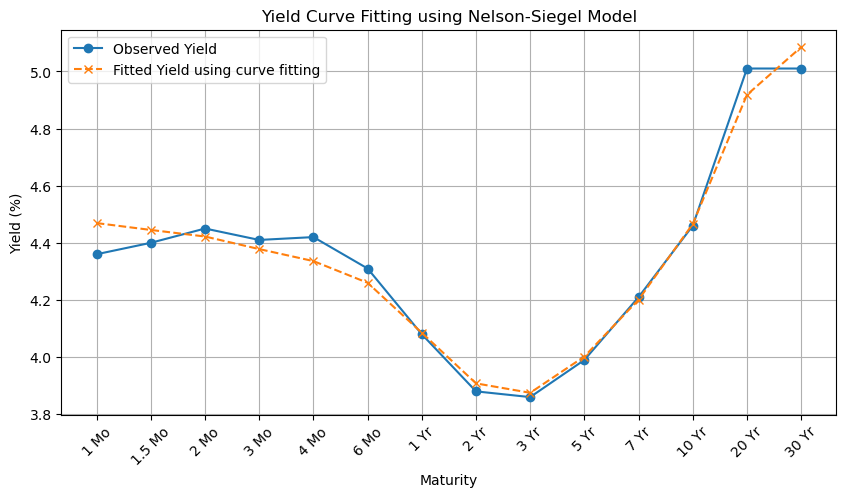

In [45]:
# Add fitted values to the DataFrame
data_7_16_2025['Fitted Yield % OLS(NS)'] = nelson_siegel_model(maturities, beta0, beta1, beta2, lambd)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % OLS(NS)'] = data_7_16_2025['Fitted Yield % OLS(NS)'].round(3)
# Plotting the original yields and fitted curve vs the maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x', linestyle='--', label='Fitted Yield using curve fitting')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


### Calibration using MLE

In [46]:
def neg_log_likelihood(params_mle, t, y):
    beta0_mle, beta1_mle, beta2_mle, lambd_mle, sigma_mle = params_mle
    y_hat = nelson_siegel_model(t, beta0_mle, beta1_mle, beta2_mle, lambd_mle)
    n = len(y)
    # NLL for Gaussian
    nll = 0.5 * n * np.log(2 * np.pi * sigma_mle ** 2) + 0.5 * np.sum((y - y_hat) ** 2) / sigma_mle ** 2
    return nll


In [47]:
initial_guess = [5.0, 1.0, 1.0, 0.1, 0.1]
bounds = [(-10, 20), (-20, 20), (-20, 20), (1e-6, 10), (1e-6, 2)]  # reasonable bounds

result = minimize(
    neg_log_likelihood,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B'
)

beta0_mle, beta1_mle, beta2_mle, lambd_mle, sigma_mle = result.x

print("Fitted parameters (MLE):")
print(f"beta0_mle = {beta0_mle:.4f}")
print(f"beta1_mle = {beta1_mle:.4f}")
print(f"beta2_mle = {beta2_mle:.4f}")
print(f"lambda_mle = {lambd_mle:.4f}")
print(f"sigma_mle = {sigma_mle:.4f}")

Fitted parameters (MLE):
beta0_mle = 5.4196
beta1_mle = -0.9010
beta2_mle = -3.6287
lambda_mle = 0.4512
sigma_mle = 0.0538


In [48]:
# adding fitted values to the DataFrame
data_7_16_2025['Fitted Yield % MLE (NS)'] = nelson_siegel_model(maturities, beta0_mle, beta1_mle, beta2_mle, lambd_mle)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % MLE (NS)'] = data_7_16_2025['Fitted Yield % MLE (NS)'].round(3)


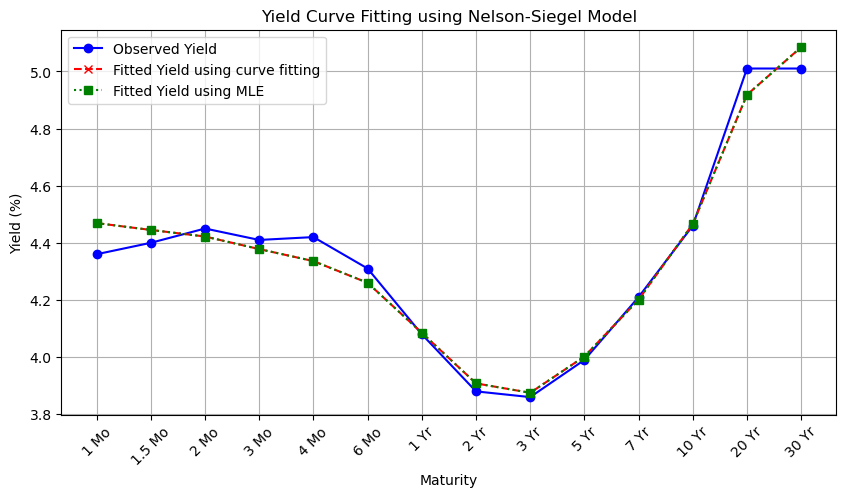

In [49]:
#plotting  original yields, fitted , MLE fitted vs maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o',color = 'b', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x',color = 'r', linestyle='--', label='Fitted Yield using curve fitting')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % MLE (NS)'], marker='s',color = 'g', linestyle=':', label='Fitted Yield using MLE')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Why did we get the same optimized parameters for mle and non linear curve fitting?
Nonlinear curve fitting (least squares) and Maximum Likelihood Estimation (MLE) both solve for the parameters that best fit your data.

If you assume Gaussian (normal) errors, then minimizing sum of squared errors (SSE) (what curve fitting does) is mathematically equivalent to maximizing the likelihood (MLE).

So both methods, when applied correctly to the same model and data, will yield the same optimal parameters.

### Testing the data

In [50]:
# find the yeild for 1 Mo, 1.5 Mo, 2 Mo, 2.5 Mo, 3 Mo, 3.5 Mo, 4 Mo, 4.5 Mo, 5 Mo, 5.5 Mo, 6 Mo, 6.5 Mo, 7 Mo, 7.5 Mo, 8 Mo, 8.5 Mo, 9 Mo, 9.5 Mo, 10 Mo, 10.5 Mo, 11 Mo, 11.5 Mo, 12 Mo, 1 Yr, 2 Yr, 3 Yr, 4 Yr, 5 Yr, 6 Yr, 7 Yr, 8 Yr, 9 Yr, 10 Yr, 11 Yr, 12 Yr, 13 Yr, 14 Yr, 15 Yr, 16 Yr, 17 Yr, 18 Yr, 19 Yr, 20 Yr, 21 Yr, 22 Yr, 23 Yr, 24 Yr, 25 Yr, 26 Yr, 27 Yr, 28 Yr, 29 Yr, 30 Yr
maturities_to_check = [1/12, 2/12, 3/12, 4/12,  5/12, 6/12,  7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
yields_to_check = nelson_siegel_model(maturities_to_check, beta0, beta1, beta2, lambd)
print("Yields for specific maturities:")
for maturity, yield_value in zip(maturities_to_check, yields_to_check):
    print(f"Maturity: {maturity:.2f} years, Yield: {yield_value:.4f} %")

# store it in a DataFrame
test_yields_df = pd.DataFrame({
    'Maturity (Years)': maturities_to_check,
    'Yield % OLS (NS)': nelson_siegel_model(maturities_to_check, beta0, beta1, beta2, lambd),})


Yields for specific maturities:
Maturity: 0.08 years, Yield: 4.4688 %
Maturity: 0.17 years, Yield: 4.4219 %
Maturity: 0.25 years, Yield: 4.3777 %
Maturity: 0.33 years, Yield: 4.3361 %
Maturity: 0.42 years, Yield: 4.2970 %
Maturity: 0.50 years, Yield: 4.2604 %
Maturity: 0.58 years, Yield: 4.2260 %
Maturity: 0.67 years, Yield: 4.1938 %
Maturity: 0.75 years, Yield: 4.1637 %
Maturity: 0.83 years, Yield: 4.1356 %
Maturity: 0.92 years, Yield: 4.1094 %
Maturity: 1.00 years, Yield: 4.0850 %
Maturity: 2.00 years, Yield: 3.9077 %
Maturity: 3.00 years, Yield: 3.8749 %
Maturity: 4.00 years, Yield: 3.9196 %
Maturity: 5.00 years, Yield: 4.0023 %
Maturity: 6.00 years, Yield: 4.1001 %
Maturity: 7.00 years, Yield: 4.2005 %
Maturity: 8.00 years, Yield: 4.2968 %
Maturity: 9.00 years, Yield: 4.3858 %
Maturity: 10.00 years, Yield: 4.4665 %
Maturity: 11.00 years, Yield: 4.5386 %
Maturity: 12.00 years, Yield: 4.6028 %
Maturity: 13.00 years, Yield: 4.6598 %
Maturity: 14.00 years, Yield: 4.7103 %
Maturity: 15.

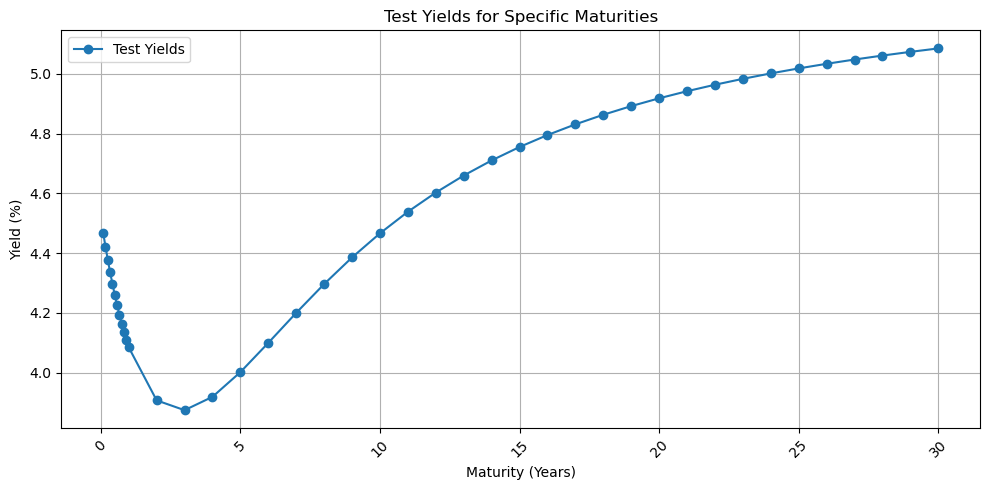

In [51]:
# plot the test yields with yields number on each point with equal spacing and the values not clashing on each other
plt.figure(figsize=(10, 5))
plt.plot(maturities_to_check, yields_to_check, marker='o', label='Test Yields')

plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [52]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=maturities_to_check,
    y=yields_to_check,
    mode='markers+lines',
    name='Test Yields',
    marker=dict(size=8)
))

fig.update_layout(
    title='Test Yields for Specific Maturities',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield (%)',
    xaxis=dict(tickangle=45),
    legend=dict(x=0.01, y=0.99),
    template='plotly_dark',  # <-- set background to black
    width=900,
    height=400
)

## Nelson Siegel Svensson Model

In [53]:
def nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambd1, lambd2):
    t = np.array(t)
    # Avoid division by zero for very small t
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd1 * t)) / (lambd1 * t)
    term2 = term1 - np.exp(-lambd1 * t)
    term3 = ((1 - np.exp(-lambd2 * t)) / (lambd2 * t)) - np.exp(-lambd2 * t)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3


In [54]:
def objective(params, t, yields):
    beta0, beta1, beta2, beta3, lambd1, lambd2 = params
    fitted = nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambd1, lambd2)
    return np.sum((yields - fitted) ** 2)

In [55]:
maturities = data_7_16_2025["Maturity (Years)"].values
yields = data_7_16_2025["Yield %"].values

# Initial guess: beta0, beta1, beta2, beta3, lambd1, lambd2
initial_guess = [5, 1.0, 1.0, 1.0, 0.5, 0.5]

# For NSS (6 parameters: beta0, beta1, beta2, beta3, lambd1, lambd2)
bounds = [(3, 6),  # beta0
          (-10, 10),  # beta1
          (-10, 10),  # beta2
          (-10, 10),  # beta3
          (0.001, 10), # lambd1
          (0.001, 10)] # lambd2


# Fit using minimize
result = minimize(
    objective,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 10000}
)


beta0, beta1, beta2, beta3, lambd1, lambd2 = result.x

print(f"Fitted parameters:")
print(f"beta0  = {beta0:.4f}")
print(f"beta1  = {beta1:.4f}")
print(f"beta2  = {beta2:.4f}")
print(f"beta3  = {beta3:.4f}")
print(f"lambda1 = {lambd1:.4f}")
print(f"lambda2 = {lambd2:.4f}")

Fitted parameters:
beta0  = 5.3432
beta1  = -0.9729
beta2  = 0.0000
beta3  = -4.8305
lambda1 = 3.8886
lambda2 = 0.5834


In [56]:
# Add fitted values to the DataFrame
data_7_16_2025['Fitted Yield % OLS(NSS)'] = nelson_siegel_svensson_model(maturities, beta0, beta1, beta2, beta3, lambd1, lambd2)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % OLS(NSS)'] = data_7_16_2025['Fitted Yield % OLS(NSS)'].round(3)

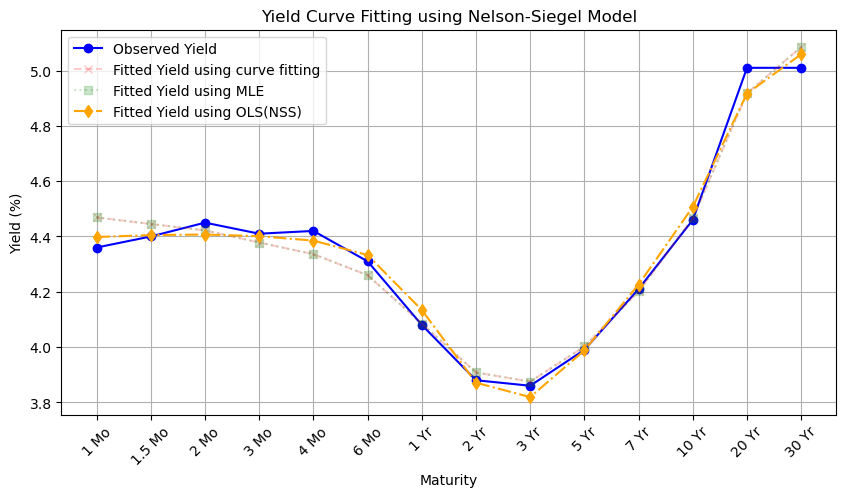

In [57]:
#plotting  original yields, fitted , MLE fitted vs maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o',color = 'b', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x',color = 'r', linestyle='--', label='Fitted Yield using curve fitting',alpha=0.2)
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % MLE (NS)'], marker='s',color = 'g', linestyle=':', label='Fitted Yield using MLE', alpha=0.2)
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NSS)'], marker='d', color='orange', linestyle='-.', label='Fitted Yield using OLS(NSS)')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Testing the data

In [58]:
# find the yeild for 1 Mo, 1.5 Mo, 2 Mo, 2.5 Mo, 3 Mo, 3.5 Mo, 4 Mo, 4.5 Mo, 5 Mo, 5.5 Mo, 6 Mo, 6.5 Mo, 7 Mo, 7.5 Mo, 8 Mo, 8.5 Mo, 9 Mo, 9.5 Mo, 10 Mo, 10.5 Mo, 11 Mo, 11.5 Mo, 12 Mo, 1 Yr, 2 Yr, 3 Yr, 4 Yr, 5 Yr, 6 Yr, 7 Yr, 8 Yr, 9 Yr, 10 Yr, 11 Yr, 12 Yr, 13 Yr, 14 Yr, 15 Yr, 16 Yr, 17 Yr, 18 Yr, 19 Yr, 20 Yr, 21 Yr, 22 Yr, 23 Yr, 24 Yr, 25 Yr, 26 Yr, 27 Yr, 28 Yr, 29 Yr, 30 Yr
maturities_to_check = [1/12, 2/12, 3/12, 4/12,  5/12, 6/12,  7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
yields_to_check = nelson_siegel_svensson_model(maturities_to_check, beta0, beta1, beta2, beta3, lambd1, lambd2)
print("Yields for specific maturities:")
for maturity, yield_value in zip(maturities_to_check, yields_to_check):
    print(f"Maturity: {maturity:.2f} years, Yield: {yield_value:.4f} %")

Yields for specific maturities:
Maturity: 0.08 years, Yield: 4.3986 %
Maturity: 0.17 years, Yield: 4.4071 %
Maturity: 0.25 years, Yield: 4.4012 %
Maturity: 0.33 years, Yield: 4.3850 %
Maturity: 0.42 years, Yield: 4.3615 %
Maturity: 0.50 years, Yield: 4.3330 %
Maturity: 0.58 years, Yield: 4.3015 %
Maturity: 0.67 years, Yield: 4.2681 %
Maturity: 0.75 years, Yield: 4.2340 %
Maturity: 0.83 years, Yield: 4.1999 %
Maturity: 0.92 years, Yield: 4.1664 %
Maturity: 1.00 years, Yield: 4.1338 %
Maturity: 2.00 years, Yield: 3.8713 %
Maturity: 3.00 years, Yield: 3.8186 %
Maturity: 4.00 years, Yield: 3.8797 %
Maturity: 5.00 years, Yield: 3.9881 %
Maturity: 6.00 years, Yield: 4.1090 %
Maturity: 7.00 years, Yield: 4.2259 %
Maturity: 8.00 years, Yield: 4.3321 %
Maturity: 9.00 years, Yield: 4.4256 %
Maturity: 10.00 years, Yield: 4.5068 %
Maturity: 11.00 years, Yield: 4.5769 %
Maturity: 12.00 years, Yield: 4.6374 %
Maturity: 13.00 years, Yield: 4.6898 %
Maturity: 14.00 years, Yield: 4.7355 %
Maturity: 15.

In [59]:
# append this to the test_yields_df DataFrame
test_yields_df['Yield % OLS (NSS)'] = yields_to_check

In [60]:
test_yields_df

,Maturity (Years),Yield % OLS (NS),Yield % OLS (NSS)
0,0.083333,4.468814,4.398567
1,0.166667,4.421879,4.407094
2,0.250000,4.377684,4.401222
3,0.333333,4.336110,4.384990
4,0.416667,4.297043,4.361481
5,0.500000,4.260371,4.333046
6,0.583333,4.225989,4.301472
7,0.666667,4.193795,4.268114
8,0.750000,4.163693,4.233998
9,0.833333,4.135588,4.199890


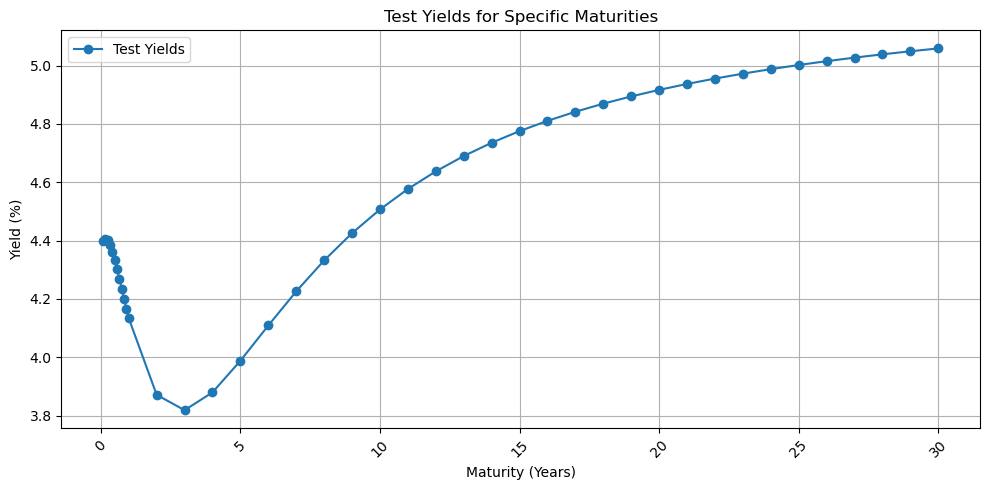

In [61]:
# plot the test yields with yields number on each point with equal spacing and the values not clashing on each other
plt.figure(figsize=(10, 5))
plt.plot(maturities_to_check, yields_to_check, marker='o', label='Test Yields')

plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [62]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=maturities_to_check,
    y=yields_to_check,
    mode='markers+lines',
    name='Test Yields',
    marker=dict(size=8)
))

fig.update_layout(
    title='Test Yields for Specific Maturities',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield (%)',
    xaxis=dict(tickangle=45),
    legend=dict(x=0.01, y=0.99),
    template='plotly_dark',  # <-- set background to black
    width=900,
    height=400
)

## Linear Interpolation

In [63]:
data_7_16_2025

,Maturity,Yield %,Maturity (Years),Fitted Yield % OLS(NS),Fitted Yield % MLE (NS),Fitted Yield % OLS(NSS)
0,1 Mo,4.36,0.083,4.469,4.469,4.398
1,1.5 Mo,4.4,0.125,4.445,4.445,4.405
2,2 Mo,4.45,0.167,4.422,4.422,4.407
3,3 Mo,4.41,0.250,4.378,4.378,4.401
4,4 Mo,4.42,0.333,4.336,4.336,4.385
5,6 Mo,4.31,0.500,4.260,4.260,4.333
6,1 Yr,4.08,1.000,4.085,4.085,4.134
7,2 Yr,3.88,2.000,3.908,3.908,3.871
8,3 Yr,3.86,3.000,3.875,3.875,3.819
9,5 Yr,3.99,5.000,4.002,4.002,3.988


In [64]:
maturities = np.array([data_7_16_2025["Maturity (Years)"].values]).flatten()
yields = np.array([data_7_16_2025["Yield %"].values]).flatten()

In [65]:
# Extract data from your DataFrame and convert to clean arrays
maturities = np.asarray(data_7_16_2025["Maturity (Years)"].values, dtype=float).flatten()
yields = np.asarray(data_7_16_2025["Yield %"].values, dtype=float).flatten()

maturities_to_interpolate = [1/12, 2/12, 3/12, 4/12,  5/12, 6/12,  7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# Interpolate yields for the desired maturities
interpolated_yields = np.interp(maturities_to_interpolate, maturities, yields)

# Display results
print("Interpolation Results:")
for i, (m, y) in enumerate(zip(maturities_to_interpolate, interpolated_yields)):
    print(f"Maturity: {m:.4f} years -> Interpolated Yield: {y:.4f}%")

Interpolation Results:
Maturity: 0.0833 years -> Interpolated Yield: 4.3603%
Maturity: 0.1667 years -> Interpolated Yield: 4.4496%
Maturity: 0.2500 years -> Interpolated Yield: 4.4100%
Maturity: 0.3333 years -> Interpolated Yield: 4.4198%
Maturity: 0.4167 years -> Interpolated Yield: 4.3649%
Maturity: 0.5000 years -> Interpolated Yield: 4.3100%
Maturity: 0.5833 years -> Interpolated Yield: 4.2717%
Maturity: 0.6667 years -> Interpolated Yield: 4.2333%
Maturity: 0.7500 years -> Interpolated Yield: 4.1950%
Maturity: 0.8333 years -> Interpolated Yield: 4.1567%
Maturity: 0.9167 years -> Interpolated Yield: 4.1183%
Maturity: 1.0000 years -> Interpolated Yield: 4.0800%
Maturity: 2.0000 years -> Interpolated Yield: 3.8800%
Maturity: 3.0000 years -> Interpolated Yield: 3.8600%
Maturity: 4.0000 years -> Interpolated Yield: 3.9250%
Maturity: 5.0000 years -> Interpolated Yield: 3.9900%
Maturity: 6.0000 years -> Interpolated Yield: 4.1000%
Maturity: 7.0000 years -> Interpolated Yield: 4.2100%
Matur

In [66]:
def linear_interpolate(x0, y0, x1, y1, x):
    return y0 + (x - x0) * (y1 - y0) / (x1 - x0)

maturities = [0.083, 0.125, 0.167, 0.25, 0.333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = [4.36, 4.4, 4.45, 4.41, 4.42, 4.31, 4.08, 3.88, 3.86, 3.99, 4.21, 4.46, 5.01, 5.01]

targets = [5/12, 7/12, 8/12, 9/12, 10/12, 11/12, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29]

def interpolate_yield(maturities, yields, x):
    # Handle if x is out of range
    if x < maturities[0] or x > maturities[-1]:
        return None  # or np.nan
    for i in range(1, len(maturities)):
        if maturities[i-1] <= x <= maturities[i]:
            return linear_interpolate(maturities[i-1], yields[i-1], maturities[i], yields[i], x)
    return None

results = []
for t in targets:
    y = interpolate_yield(maturities, yields, t)
    results.append((t, y))

# Print nicely
for t, y in results:
    if y is not None:
        print(f"Maturity: {t:.4f} years -> Interpolated Yield: {y:.4f}%")
    else:
        print(f"Maturity: {t:.4f} years -> Out of range")


Maturity: 0.4167 years -> Interpolated Yield: 4.3649%
Maturity: 0.5833 years -> Interpolated Yield: 4.2717%
Maturity: 0.6667 years -> Interpolated Yield: 4.2333%
Maturity: 0.7500 years -> Interpolated Yield: 4.1950%
Maturity: 0.8333 years -> Interpolated Yield: 4.1567%
Maturity: 0.9167 years -> Interpolated Yield: 4.1183%
Maturity: 4.0000 years -> Interpolated Yield: 3.9250%
Maturity: 6.0000 years -> Interpolated Yield: 4.1000%
Maturity: 8.0000 years -> Interpolated Yield: 4.2933%
Maturity: 9.0000 years -> Interpolated Yield: 4.3767%
Maturity: 11.0000 years -> Interpolated Yield: 4.5150%
Maturity: 12.0000 years -> Interpolated Yield: 4.5700%
Maturity: 13.0000 years -> Interpolated Yield: 4.6250%
Maturity: 14.0000 years -> Interpolated Yield: 4.6800%
Maturity: 15.0000 years -> Interpolated Yield: 4.7350%
Maturity: 16.0000 years -> Interpolated Yield: 4.7900%
Maturity: 17.0000 years -> Interpolated Yield: 4.8450%
Maturity: 18.0000 years -> Interpolated Yield: 4.9000%
Maturity: 19.0000 ye

In [67]:
# merge the results with the maturities and yields lists
results_df = pd.DataFrame(results, columns=['Maturity (Years)', 'Interpolated Yield (%)'])
results_df['Maturity (Years)'] = results_df['Maturity (Years)']
results_df['Interpolated Yield (%)'] = results_df['Interpolated Yield (%)']

maturities = [0.083, 0.125, 0.167, 0.25, 0.333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = [4.36, 4.4, 4.45, 4.41, 4.42, 4.31, 4.08, 3.88, 3.86, 3.99, 4.21, 4.46, 5.01, 5.01]

# Create a DataFrame for the original maturities and yields
original_df = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Yield (%)': yields
})

# Merge the original DataFrame with the results DataFrame
merged_df = pd.merge(original_df, results_df, on='Maturity (Years)', how='outer', suffixes=('_Original', '_Interpolated'))


# create an other column with both original and interpolated yields
merged_df['Final Yield (%)'] = merged_df['Yield (%)'].combine_first(merged_df['Interpolated Yield (%)'])


In [68]:
# append this to the test_yields_df DataFrame
test_yields_df['Yield % (LI)'] = merged_df['Final Yield (%)']

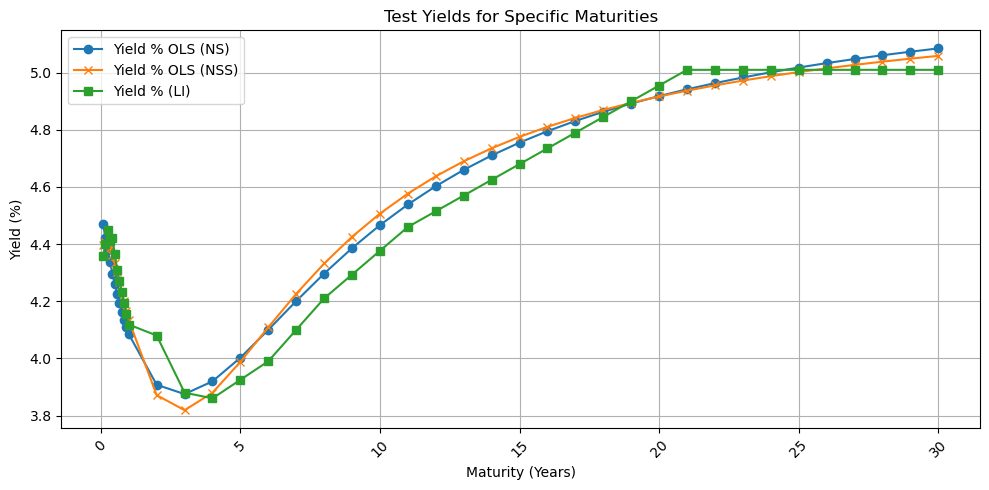

In [69]:
# plot the test_yields_df
plt.figure(figsize=(10, 5))
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NS)'], marker='o', label='Yield % OLS (NS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NSS)'], marker='x', label='Yield % OLS (NSS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % (LI)'], marker='s', label='Yield % (LI)')
plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Cubic Spline Interpolation

In [73]:
from scipy.interpolate import CubicSpline

# Prepare the original maturities and yields as arrays
maturities_array = np.array(original_df['Maturity (Years)'])
yields_array = np.array(original_df['Yield (%)'])

# Create cubic spline interpolator
cs = CubicSpline(maturities_array, yields_array)

# Interpolate for the desired maturities
cubic_spline_yields = cs(maturities_to_check)

# Add results to test_yields_df
test_yields_df['Yield % (CS)'] = cubic_spline_yields



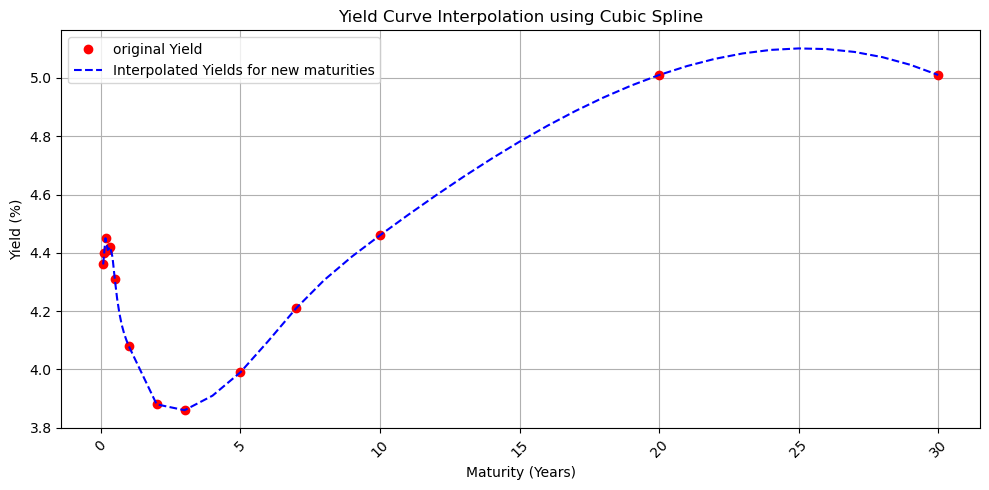

In [80]:
# plotting 
plt.figure(figsize=(10, 5))
plt.plot(maturities, yields,'o',color= 'red', label='original Yield')
plt.plot(maturities_to_check, test_yields_df['Yield % (CS)'], '--', color='blue', label = 'Interpolated Yields for new maturities')
plt.title('Yield Curve Interpolation using Cubic Spline')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Conclusion

## plots

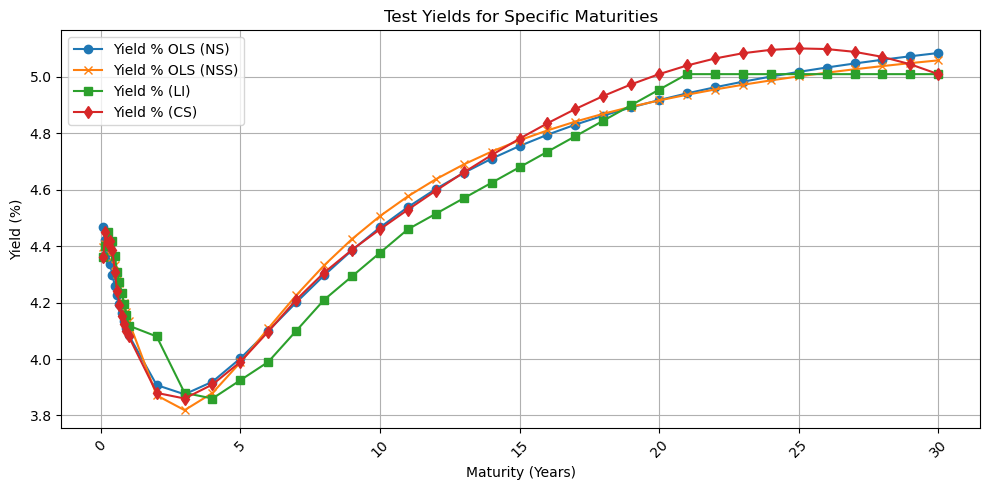

In [74]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NS)'], marker='o', label='Yield % OLS (NS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % OLS (NSS)'], marker='x', label='Yield % OLS (NSS)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % (LI)'], marker='s', label='Yield % (LI)')
plt.plot(test_yields_df['Maturity (Years)'], test_yields_df['Yield % (CS)'], marker='d', label='Yield % (CS)')
plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [86]:
data_7_16_2025

,Maturity,Yield %,Maturity (Years),Fitted Yield % OLS(NS),Fitted Yield % MLE (NS),Fitted Yield % OLS(NSS)
0,1 Mo,4.36,0.083,4.469,4.469,4.398
1,1.5 Mo,4.4,0.125,4.445,4.445,4.405
2,2 Mo,4.45,0.167,4.422,4.422,4.407
3,3 Mo,4.41,0.250,4.378,4.378,4.401
4,4 Mo,4.42,0.333,4.336,4.336,4.385
5,6 Mo,4.31,0.500,4.260,4.260,4.333
6,1 Yr,4.08,1.000,4.085,4.085,4.134
7,2 Yr,3.88,2.000,3.908,3.908,3.871
8,3 Yr,3.86,3.000,3.875,3.875,3.819
9,5 Yr,3.99,5.000,4.002,4.002,3.988


In [87]:
test_yields_df

,Maturity (Years),Yield % OLS (NS),Yield % OLS (NSS),Yield % (LI),Yield % (CS)
0,0.083333,4.468814,4.398567,4.360000,4.360021
1,0.166667,4.421879,4.407094,4.400000,4.449821
2,0.250000,4.377684,4.401222,4.450000,4.410000
3,0.333333,4.336110,4.384990,4.410000,4.420028
4,0.416667,4.297043,4.361481,4.420000,4.385813
5,0.500000,4.260371,4.333046,4.364890,4.310000
6,0.583333,4.225989,4.301472,4.310000,4.242651
7,0.666667,4.193795,4.268114,4.271667,4.191201
8,0.750000,4.163693,4.233998,4.233333,4.152431
9,0.833333,4.135588,4.199890,4.195000,4.123121


## Error metrics

In [85]:
# Actual yields
y_actual = data_7_16_2025['Yield %']

# Fitted yields for each model
y_ns = data_7_16_2025['Fitted Yield % OLS(NS)']
y_nss = data_7_16_2025['Fitted Yield % OLS(NSS)']

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# NS Model
rmse_ns = rmse(y_actual, y_ns)
mae_ns = mae(y_actual, y_ns)

# NSS Model
rmse_nss = rmse(y_actual, y_nss)
mae_nss = mae(y_actual, y_nss)

print(f"NS Model: RMSE = {rmse_ns:.4f}, MAE = {mae_ns:.4f}")
print(f"NSS Model: RMSE = {rmse_nss:.4f}, MAE = {mae_nss:.4f}")


NS Model: RMSE = 0.0539, MAE = 0.0421
NSS Model: RMSE = 0.0408, MAE = 0.0331


## Parameter stability